In [1]:
from numpy import genfromtxt
import numpy as np
import torch

import matplotlib.pyplot as plt
import sklearn.datasets
from torch.utils.data import Dataset, DataLoader, TensorDataset

import math

from tqdm import tqdm

# Logistic Regression

In [2]:
my_data = genfromtxt('/content/wbca.csv', delimiter = ',', skip_header = 1)

In [3]:
my_data

array([[ 1.,  1.,  1., ...,  5.,  1.,  1.],
       [ 1.,  5., 10., ...,  5.,  4.,  4.],
       [ 1.,  1.,  2., ...,  3.,  1.,  1.],
       ...,
       [ 0.,  3.,  3., ...,  5., 10., 10.],
       [ 0.,  4.,  4., ...,  4.,  6.,  8.],
       [ 0.,  5.,  5., ...,  4.,  8.,  8.]])

In [4]:
Y = my_data[:,0]
X = my_data[:,1:]

X.mean(axis = 0) #[9,]

array([2.8164464 , 3.54185022, 3.43318649, 3.23054332, 1.60352423,
       2.85903084, 4.43612335, 3.2041116 , 3.13950073])

In [5]:
std_X = (X-X.mean(axis = 0))/ X.std(axis = 0)

In [6]:
n = X.shape[0]
n

681

In [7]:
std_X = torch.tensor(std_X,dtype = torch.float32) # [n,9]: dtype = float32
Y = torch.tensor(Y, dtype = torch.float32).reshape([-1,1]) # [n,] -> [n,1]: dtype = float32


In [8]:
X_mod1 = torch.stack((std_X[:,1],std_X[:,6]), dim = 1) # index of BNul = 1, index of Thick = 6 in X

print(X_mod1[:5,:])
print(std_X[:5,:])

tensor([[-0.6976,  0.2000],
        [ 1.7724,  0.2000],
        [-0.4232, -0.5094],
        [ 0.1257,  0.5547],
        [-0.6976, -0.1547]])
tensor([[-0.6369, -0.6976, -0.1774, -0.5534, -0.3481, -0.6100,  0.2000, -0.7398,
         -0.7001],
        [ 0.7656,  1.7724, -0.1774,  1.6953, -0.3481, -0.2819,  0.2000,  0.2671,
          0.2816],
        [-0.6369, -0.4232, -0.1774, -0.5534, -0.3481, -0.6100, -0.5094, -0.7398,
         -0.7001],
        [-0.6369,  0.1257, -0.1774, -0.1037, -0.3481,  1.3588,  0.5547,  1.6097,
          1.5905],
        [ 0.0644, -0.6976, -0.1774, -0.5534, -0.3481, -0.6100, -0.1547, -0.7398,
         -0.7001]])


In [10]:
dataset1 = TensorDataset(X_mod1,Y)
trainloader1 = DataLoader(dataset=dataset1, batch_size=32, shuffle=True)

dataset2 = TensorDataset(std_X,Y)
trainloader2 = DataLoader(dataset=dataset2, batch_size=32, shuffle=True)

In [11]:
model1 = torch.nn.Linear(2,1, bias=True)
model2 = torch.nn.Linear(9,1, bias=True)


def neg_log_lik(phat,y):
    out = -1 * torch.mean(y * torch.log(phat) + (1 - y) * torch.log(1 - phat))
    return out

my_optimizer1 = torch.optim.SGD(model1.parameters(), lr = 0.1)
my_optimizer2 = torch.optim.SGD(model2.parameters(), lr = 0.1)

## training of Mod1

In [12]:
epochs=100
history1=[]


for epoch in range(epochs):
  LOSS_sum = 0
  for xx, yy in trainloader1:
    z = model1(xx)
    phat = torch.sigmoid(z)
    loss = neg_log_lik(phat, yy)
    LOSS_sum = LOSS_sum + loss * len(yy)
    my_optimizer1.zero_grad()
    loss.backward()
    my_optimizer1.step()

  history1.append(LOSS_sum.item()/n)


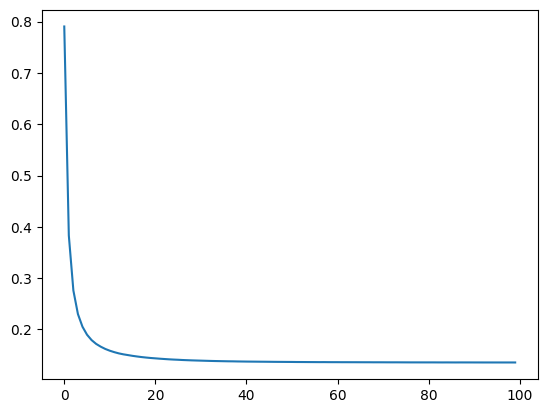

In [13]:
plt.plot(history1)

## training of Mod2

In [14]:
epochs=100
history2=[]


for epoch in range(epochs):
  LOSS_sum = 0
  for xx, yy in trainloader2:
    z = model2(xx)
    phat = torch.sigmoid(z)
    loss = neg_log_lik(phat, yy)
    LOSS_sum = LOSS_sum + loss * len(yy)
    my_optimizer2.zero_grad()
    loss.backward()
    my_optimizer2.step()
  history2.append(LOSS_sum.item()/n)


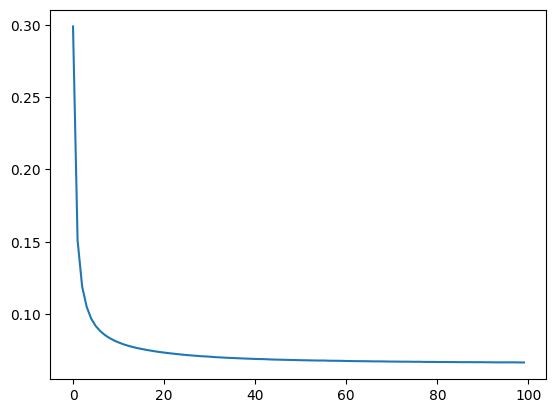

In [15]:
plt.plot(history2)

In [16]:
# accuracy
def accuracy(std_X, Y ,cri = "model1"):
    if cri == "model1":
        Z = model1(std_X)
    elif cri == "model2":
        Z = model2(std_X)

    Phat = torch.sigmoid(Z)
    Yhat = torch.where(Phat > 0.5, 1,0)

    return torch.mean( (Y == Yhat).float()) # total parameter result :  tensor(0.9706)

In [18]:
accuracy(X_mod1, Y, "model1")

tensor(0.9501)

In [19]:
accuracy(std_X, Y, "model2")

tensor(0.9706)

In [17]:
Y.shape

torch.Size([681, 1])

## CV

In [20]:
indexset = torch.tensor(np.arange(n), dtype = torch.int32)
Trainloader = DataLoader(dataset=indexset, batch_size=math.ceil(n/10), shuffle=False)

### CV of model1


100%|██████████| 100/100 [00:00<00:00, 753.56it/s]


tensor(0.9511)


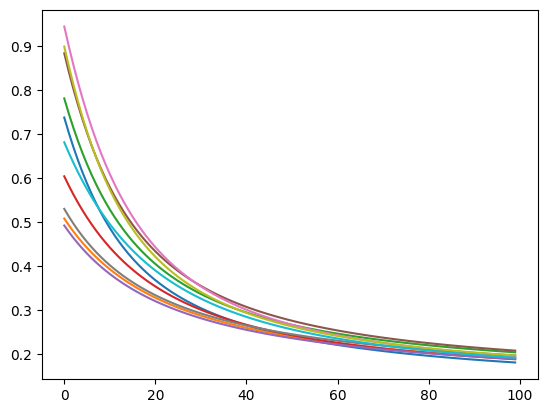

In [21]:
epochs=100
history=[]

Acc1 = 0
accuracy = []

for test in Trainloader:
    X_test = X_mod1[test,:]
    Y_test = Y[test, :]
    X_train = np.delete(X_mod1,test,axis = 0)
    Y_train =  np.delete(Y,test,axis = 0)

    model1 = torch.nn.Linear(2,1, bias = True)
    my_optimizer = torch.optim.SGD(model1.parameters(), lr = 0.1)

    history1 = []


    for epoch in tqdm(range(100)):
        z = model1(X_train)
        phat = torch.sigmoid(z)
        loss = neg_log_lik(phat, Y_train)

        my_optimizer.zero_grad()
        loss.backward()

        my_optimizer.step()

        history1.append(loss.item())

    plt.plot(history1)

    Z = model1(X_test)
    Phat = torch.sigmoid(Z)
    Yhat = torch.where(Phat > 0.5, 1,0)
    accuracy.append(torch.mean( (Y_test == Yhat).float()))


Acc1 = torch.mean(torch.stack(accuracy))


In [24]:
print(Acc1)

tensor(0.9511)


### CV of model2

100%|██████████| 100/100 [00:00<00:00, 1289.49it/s]


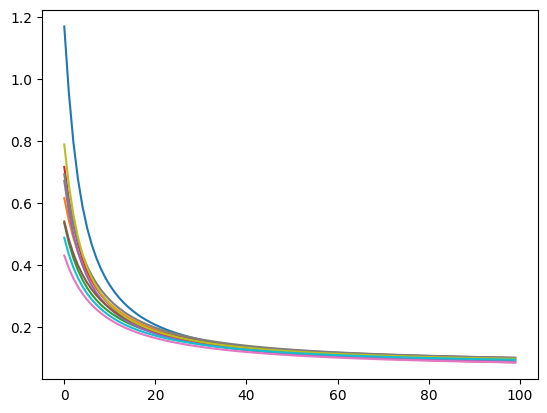

In [22]:
epochs=100
history=[]

Acc2 = 0
accuracy = []

for test in Trainloader:
    X_test = std_X[test,:]
    Y_test = Y[test, :]
    X_train = np.delete(std_X,test,axis = 0)
    Y_train =  np.delete(Y,test,axis = 0)

    model2 = torch.nn.Linear(9,1, bias = True)
    my_optimizer = torch.optim.SGD(model2.parameters(), lr = 0.1)

    history2 = []


    for epoch in tqdm(range(100)):
        z = model2(X_train)
        phat = torch.sigmoid(z)
        loss = neg_log_lik(phat, Y_train)

        my_optimizer.zero_grad()
        loss.backward()

        my_optimizer.step()

        history2.append(loss.item())

    plt.plot(history2)

    Z = model2(X_test)
    Phat = torch.sigmoid(Z)
    Yhat = torch.where(Phat > 0.5, 1,0)
    accuracy.append(torch.mean( (Y_test == Yhat).float()))


Acc2 = torch.mean(torch.stack(accuracy))

In [23]:
Acc2

tensor(0.9708)

# Poisson regression

model  
$ y \sim Pois(exp(X\beta)) $  
$ ca \sim log(cells) + log(doserate) * dosef $  
$X = [log(cells) \quad log(doserate) * dosef \quad log(doserate) \quad dosef], shape = (-1,4) $

In [25]:
dicentric = genfromtxt('/content/dicentric.csv', delimiter = ',', skip_header = 1)

Y = dicentric[:,1] # target: ca
X = np.delete (dicentric, 1, axis = 1)

X.shape

(27, 3)

it seems to only normalize for cells  
but, we take $log$ so, do not normalization for each paramter

In [43]:
print( f'mean: {np.mean(X, axis = 0)} \n std: {np.std(X, axis = 0)}')

mean: [640.7037037    2.83333333   1.65      ] 
 std: [688.50357404   1.64991582   1.26139253]


In [47]:
X = torch.tensor(X, dtype = torch.float32)
Y = torch.tensor(Y, dtype = torch.float32)
Y = Y.reshape(-1,1)

In [48]:
torch.log(X[:,0])

tensor([6.1696, 7.5533, 7.7222, 7.7532, 7.1213, 7.3072, 7.3251, 6.6386, 7.2204,
        5.7930, 5.2204, 5.8348, 5.7366, 5.6276, 5.5568, 5.5175, 5.6971, 5.4931,
        5.3471, 4.9273, 5.0752, 4.7875, 4.4998, 4.6052, 5.7462, 5.2040, 4.9698])

In [49]:
X.shape

torch.Size([27, 3])

In [50]:
# parameter = log(cells) , log(doserate) log(doserate) * dosef, dosef
X_mod1 = torch.stack((torch.log(X[:,0]), torch.log(X[:,1]), torch.log(X[:,1]) * X[:,2], X[:,2]), dim = 1)

In [51]:
def criterion(yhat, yy):
  temp = -torch.mean(-yhat + yy*torch.log(yhat)-torch.lgamma(yy+1))
  return temp

make cross validation set

In [80]:
n = X_mod1.shape[0]

dataset1 = TensorDataset(X_mod1,Y)
trainloader1 = DataLoader(dataset=dataset1, batch_size=32, shuffle=True)

indexset = torch.tensor(np.arange(n), dtype = torch.int32)
Trainloader = DataLoader(dataset=indexset, batch_size=math.ceil(n/10), shuffle=False)

100%|██████████| 100/100 [00:00<00:00, 1485.98it/s]


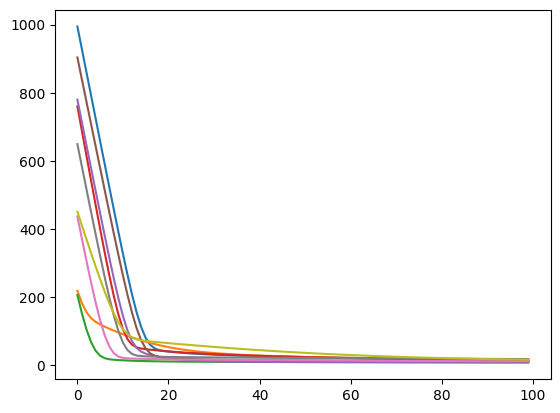

In [101]:
epochs=100
history=[]

MSE1 = 0
mse = []

for test in Trainloader:
    X_test = X_mod1[test,:]
    Y_test = Y[test, :]
    X_train = np.delete(X_mod1,test,axis = 0)
    Y_train =  np.delete(Y,test,axis = 0)

    model1 = torch.nn.Linear(4,1, bias = True)
    my_optimizer = torch.optim.SGD(model1.parameters(), lr = 0.0001)

    history1 = []


    for epoch in tqdm(range(100)):
        z = model1(X_train)
        yhat = torch.exp(z)
        loss = criterion(yhat, Y_train)

        my_optimizer.zero_grad()

        loss.backward()

        my_optimizer.step()

        history1.append(loss.item())

    plt.plot(history1)

    Z = model1(X_test)
    Yhat = torch.exp(Z)
    mse.append(torch.mean((Y_test - Yhat)**2))


MSE1 = torch.mean(torch.stack(mse))

In [102]:
MSE1

tensor(4647.3252, grad_fn=<MeanBackward0>)